# Ridge regression with polynomial features of degree 2
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os
import scipy.stats as st

In [2]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.ridge-poly','true')

In [3]:
model_name = "ridge_poly2"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical features.
- create polynomial features of degree 2. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1, x_2, x_1^2, x_1x_2, x_2^2)$
- randomized parameter search with cross validation to find optimal values for the alpha parameter

Note - to limit the training time, the number of iterations for the randomized search has been set to 20. This should train in about 3 minutes. increasing the number of iterations will increase the likelihood of finding the optimum solution but also increase training times. 

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
poly = PolynomialFeatures(2)
tscv = TimeSeriesSplit(n_splits=3)

In [7]:
param_dist = {'alpha': st.uniform(1e-4, 5.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=1)
regr_pipe = Pipeline([('onehot', onehot), ('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] alpha=4.90403025516 .............................................
[CV] .............................. alpha=4.90403025516, total=   0.8s
[CV] alpha=4.90403025516 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .............................. alpha=4.90403025516, total=   1.4s
[CV] alpha=4.90403025516 .............................................
[CV] .............................. alpha=4.90403025516, total=   2.1s
[CV] alpha=1.41255238507 .............................................
[CV] .............................. alpha=1.41255238507, total=   0.8s
[CV] alpha=1.41255238507 .............................................
[CV] .............................. alpha=1.41255238507, total=   1.4s
[CV] alpha=1.41255238507 .............................................
[CV] .............................. alpha=1.41255238507, total=   2.1s
[CV] alpha=3.76275618078 .............................................
[CV] .............................. alpha=3.76275618078, total=   0.8s
[CV] alpha=3.76275618078 .............................................
[CV] .............................. alpha=3.76275618078, total=   1.4s
[CV] alpha=3.76275618078 .............................................
[CV] .

[CV] .............................. alpha=1.74900498531, total=   2.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.6min finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_trai...=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2))])

In [8]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [9]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,1.661420,0.015016,-1247.836161,-1044.319558,0.879543,{'alpha': 0.879542881096},1,-1373.651814,-1012.003444,-1078.397714,-1076.942261,-1291.458956,-1044.012970,0.700400,0.000166,124.421212,26.512047
4,1.443228,0.018448,-1247.912906,-1043.642910,0.803025,{'alpha': 0.803024610676},2,-1373.757923,-1010.842679,-1078.372787,-1076.423058,-1291.608008,-1043.662993,0.530786,0.002507,124.485718,26.773081
9,1.435197,0.014523,-1247.945671,-1047.321469,1.23704,{'alpha': 1.23704128253},3,-1374.232920,-1017.238619,-1078.592770,-1079.185839,-1291.011324,-1045.539949,0.508223,0.000093,124.476938,25.321202
1,1.432041,0.014388,-1248.221380,-1048.733526,1.41255,{'alpha': 1.41255238507},4,-1375.032865,-1019.740081,-1078.727171,-1080.218669,-1290.904102,-1046.241826,0.550469,0.000229,124.674582,24.753065
14,1.710671,0.021883,-1248.956071,-1051.119795,1.71585,{'alpha': 1.71584870664},5,-1377.008919,-1024.004186,-1079.015052,-1081.948600,-1290.844242,-1047.406598,0.588769,0.007859,125.209292,23.800975


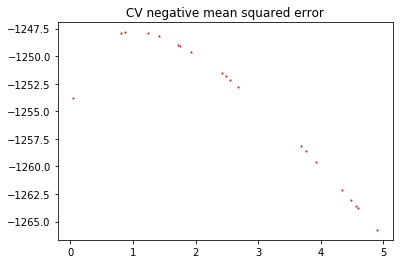

In [10]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()